In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import time
import os 
warnings.filterwarnings('ignore') 

from matplotlib import pyplot as plt 
from IPython.display import clear_output

from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern
from sklearn.preprocessing import MinMaxScaler
import numpy as np

os.chdir("/Users/satya/Documents/sklearn-bax/")
plt.style.use("mpl_style/matplotlib.rc")

from src.utils import XY_from_csv, random_sampling_no_replace
from src.acquisition import multi_infobax_gp
from src.algorithms import MultiRegionSetUnion, MultiRegionSetIntersection, GlobalOptimization1D, ParetoFront
from src.models import MGPR



In [2]:
X, Y = XY_from_csv("datasets/ssrl_ternary.csv", columns_x=["c_Fe","c_Co"], columns_y=["coer", "kerr"])


x_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)


if len(Y.shape) == 1:
    Y = Y.reshape(-1, 1)

In [3]:
algorithm = MultiRegionSetIntersection(threshold_list = [[2.0, 4.0], [0.3, 0.4]], scalers = scalers)
# algorithm = ParetoFront(tolerance_list = [0.01, 0.01],  max_or_min_list = [0, 1], scalers = scalers)
true_target_ids = algorithm.identify_subspace(x=X, y=Y)

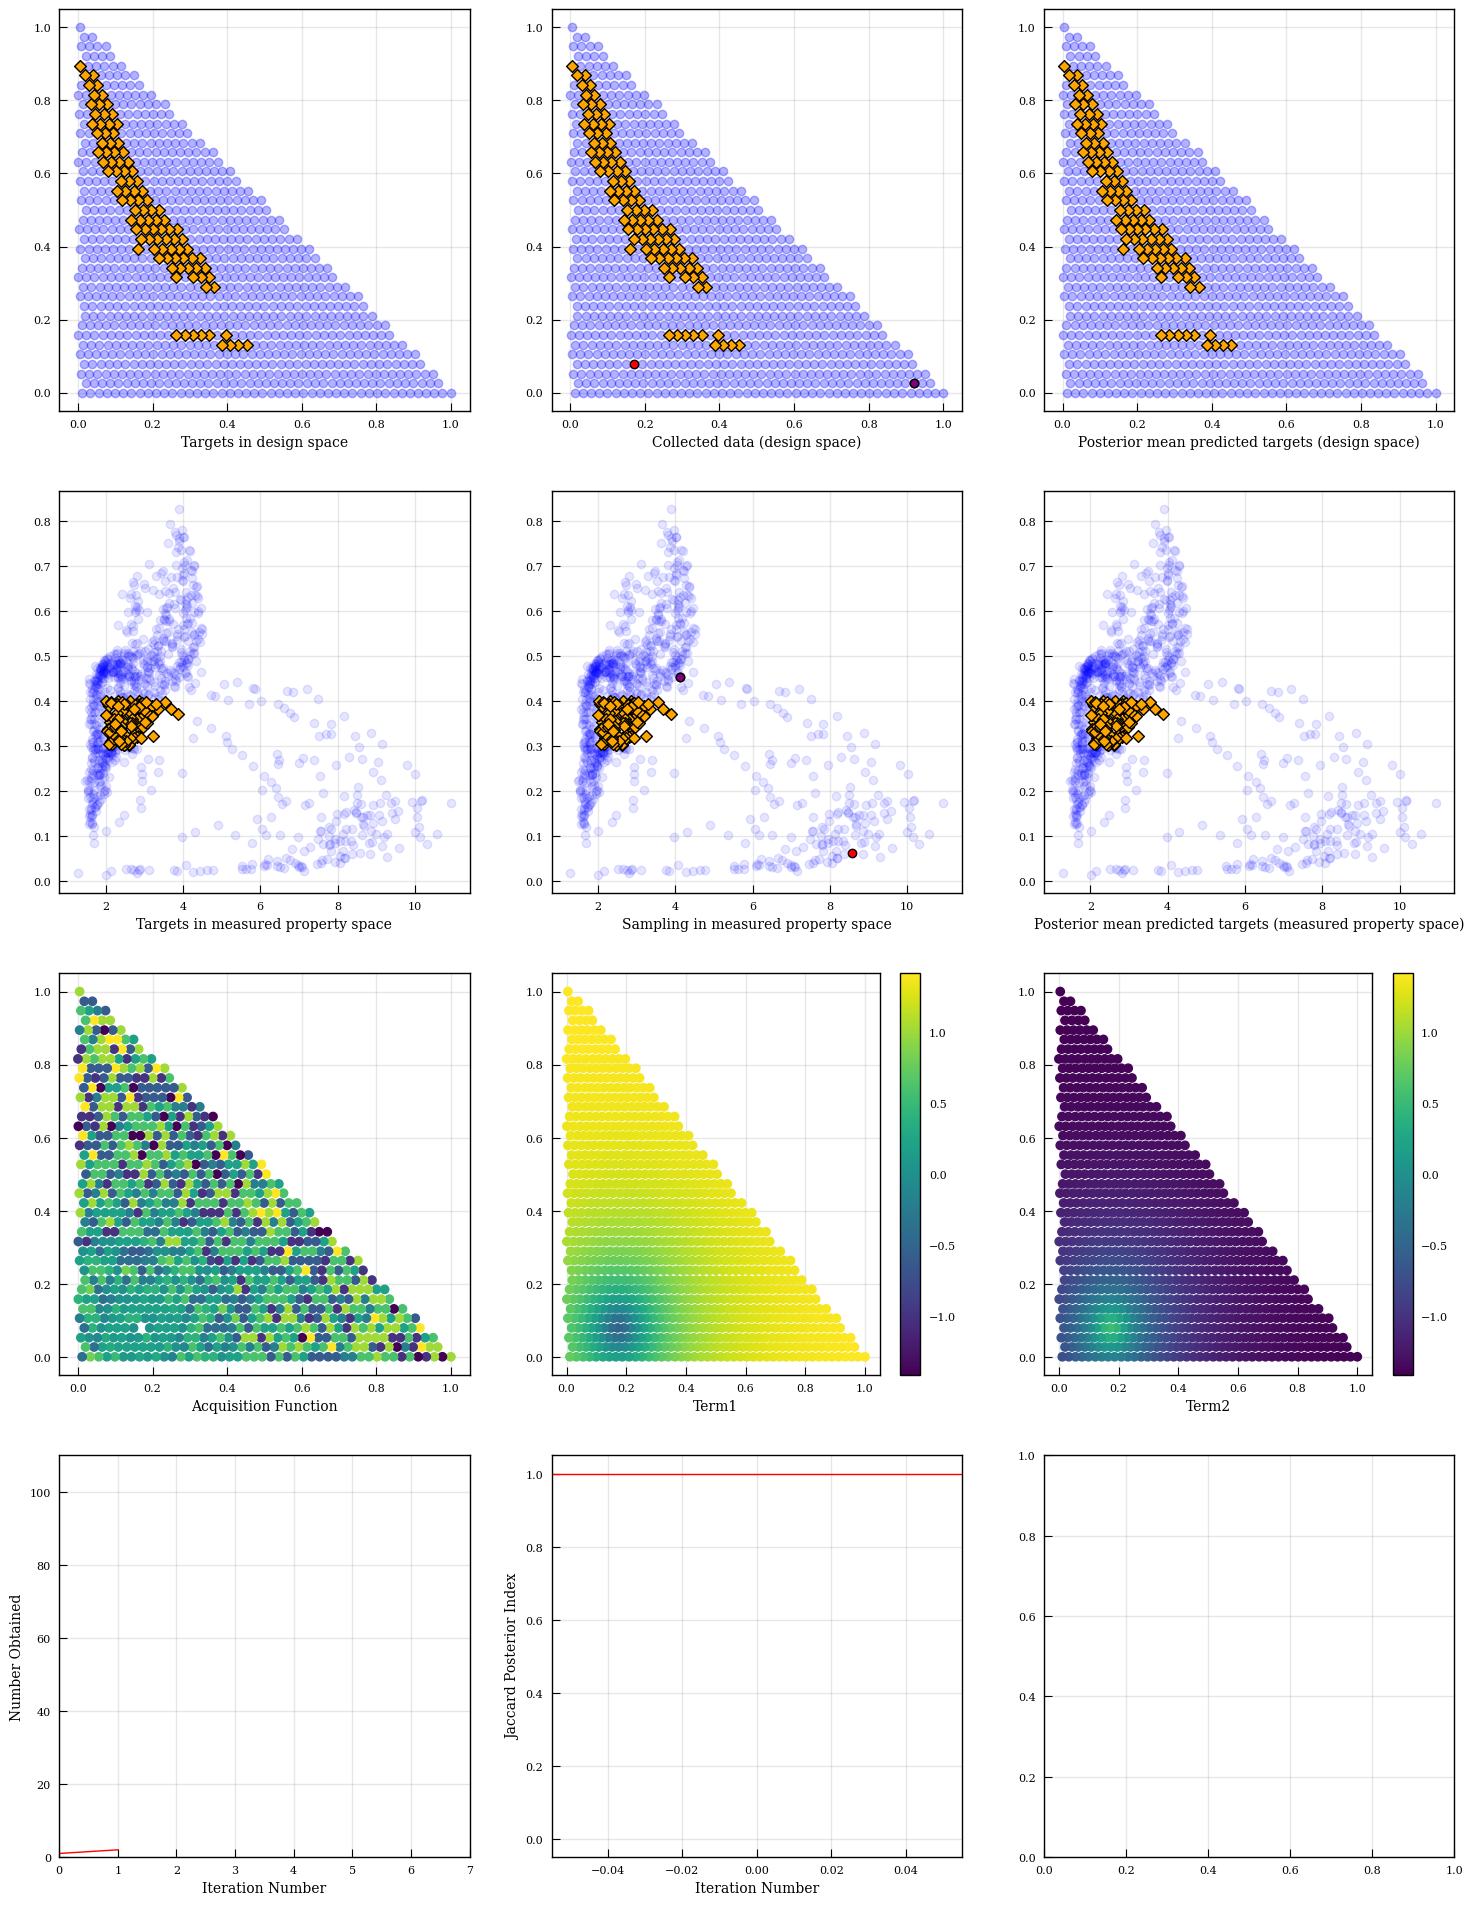

In [4]:
np.random.seed(2)


all_ids = list(np.arange(0, len(X)))
true_target_ids = algorithm.identify_subspace(x=X, y=Y)
true_not_target_ids = list(set(all_ids) - set(true_target_ids))

n_posterior_samples = 20
n_initial = 1 
train_indices = list(np.random.choice(all_ids, n_initial))
x_train = X[train_indices]
y_train = Y[train_indices]
n_features = X.shape[1]

# kernel_list = [2.0 * Matern(length_scale=1.0, length_scale_bounds='fixed') + WhiteKernel(0.01), 2.0 * Matern(length_scale=1.0, length_scale_bounds='fixed') + WhiteKernel(0.01)]
k = ConstantKernel(constant_value = 1.0) * Matern(length_scale=n_features * [0.5]) + WhiteKernel(0.01)

kernel_list = [k, k]

assert len(kernel_list) == y_train.shape[1]

collected_ids = list(train_indices)
plot_frequency = 5
prevent_requery = True 
n_obtained = [] 
jaccard_posterior = [] 
n_iters = 2 

random_sampling = [random_sampling_no_replace(len(X), len(true_target_ids), n) for n in range(n_initial, n_iters)]

for i in range(n_iters):
    multi_gpr = MGPR(kernel_list=kernel_list)
    
    acquisition_function, multi_gpr, term1, term2 = multi_infobax_gp(x_domain = X, x_train = x_train, y_train = y_train, model = multi_gpr, algorithm = algorithm, n_posterior_samples=20, verbose=False)

    vmax = np.max([np.max(term1), np.max(term2)])
    vmin = np.min([np.min(term1), np.min(term2)])


    # multi_infobax_gp(x_domain = X, x_train = x_train, y_train = y_train, model = multi_gpr, algorithm = algorithm, n_posterior_samples = 20,)
    acquisition_function = (acquisition_function - np.min(acquisition_function))/(np.max(acquisition_function) - np.min(acquisition_function))
    opt_acquisition_function = acquisition_function
    
    if prevent_requery:
        opt_acquisition_function[collected_ids] = -np.inf

    next_id = np.argmax(opt_acquisition_function)
    collected_ids.append(next_id)
    n_obtained.append(len(set(collected_ids).intersection(set(true_target_ids))))

    if n_iters <= len(true_target_ids):
        best_possible_n_obtained = np.arange(n_initial, n_iters + n_initial)
    else:
        best_possible_n_obtained = list(np.arange(n_initial,len(true_target_ids))) + list(len(true_target_ids)*np.ones(n_iters + n_initial - len(true_target_ids)))


    posterior_mean, posterior_std = multi_gpr.predict(X)
    predicted_target_ids = algorithm.identify_subspace(x=X, y=posterior_mean)

    jaccard = len(set(predicted_target_ids).intersection(set(true_target_ids)))/len(set(predicted_target_ids).union(set(true_target_ids)))
    jaccard_posterior.append(jaccard)

    if i % plot_frequency == 0:
        fig, axes = plt.subplots(4, 3, dpi=100, figsize=(18, 24))
        axes[0,0].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
        axes[0,0].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
        axes[0,0].set_xlabel('Targets in design space')

        axes[0,1].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
        axes[0,1].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
        axes[0,1].scatter(X[collected_ids, 0], X[collected_ids, 1], color='red', edgecolor='k')
        axes[0,1].scatter(X[collected_ids, 0][-1], X[collected_ids, 1][-1], color='purple', edgecolor='k')
        axes[0,1].set_xlabel('Collected data (design space)')

        axes[0,2].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
        axes[0,2].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
        axes[0,2].scatter(X[predicted_target_ids, 0], X[predicted_target_ids, 1], color='maroon', marker = 'x')
        axes[0,2].set_xlabel('Posterior mean predicted targets (design space)')

        if Y.shape[1] > 1:
            Y_norm = y_scaler.inverse_transform(Y)
            axes[1,0].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
            axes[1,0].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
            axes[1,0].set_xlabel('Targets in measured property space')
       
            axes[1,1].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
            axes[1,1].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
            axes[1,1].scatter(Y_norm[collected_ids, 0], Y_norm[collected_ids, 1], color='red', edgecolor='k')
            axes[1,1].scatter(Y_norm[collected_ids, 0][-1], Y_norm[collected_ids, 1][-1], color='purple', edgecolor='k')
            axes[1,1].set_xlabel('Sampling in measured property space')

            axes[1,2].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
            axes[1,2].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
            axes[1,2].scatter(Y_norm[predicted_target_ids, 0], Y_norm[predicted_target_ids, 1], color='maroon', marker ='x')
            axes[1,2].set_xlabel('Posterior mean predicted targets (measured property space)')
        else:
            pass


        axes[2,0].scatter(X[:, 0], X[:, 1], c=acquisition_function)
        axes[2,0].set_xlabel('Acquisition Function')

        t1 = axes[2,1].scatter(X[:, 0], X[:, 1], c=term1, vmin=vmin, vmax=vmax)
        axes[2,1].set_xlabel('Term1')
        fig.colorbar(t1, ax=axes[2,1])

        t2 = axes[2,2].scatter(X[:, 0], X[:, 1], c=term2, vmin=vmin, vmax=vmax)
        axes[2,2].set_xlabel('Term2')
        fig.colorbar(t2, ax=axes[2,2])

        try:
            axes[3,0].plot(np.arange(0, len(n_obtained)), n_obtained, color='k')
            axes[3,0].plot(best_possible_n_obtained, color='r')
            axes[3,0].plot(random_sampling, color='r')
            axes[3,0].set_xlabel('Iteration Number')
            axes[3,0].set_ylabel('Number Obtained')
            axes[3,0].set_ylim(0, 1.1 * len(true_target_ids))
            axes[3,0].set_xlim(0, len(collected_ids) + 5)
        except:
            pass
        
        try:
            axes[3,1].axhline(y=1.0, color='r', linestyle='-')
            axes[3,1].plot(np.arange(0, len(jaccard_posterior)), jaccard_posterior, color='k')
            axes[3,1].set_xlabel('Iteration Number')
            axes[3,1].set_ylabel('Jaccard Posterior Index')
        except:
            pass
        plt.show()


    x_next = X[next_id]
    y_next = Y[next_id]

    x_train = np.vstack((x_train, x_next))
    y_train = np.vstack((y_train, y_next))

        # Wait for 1 second
    time.sleep(1)
    
    # Clear the output
    clear_output(wait=True)




In [9]:
multi_gpr.models[0].get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': 1**2 * Matern(length_scale=[0.5, 0.5], nu=1.5),
 'kernel__k2': WhiteKernel(noise_level=0.01),
 'kernel__k1__k1': 1**2,
 'kernel__k1__k2': Matern(length_scale=[0.5, 0.5], nu=1.5),
 'kernel__k1__k1__constant_value': 1.0,
 'kernel__k1__k1__constant_value_bounds': 'fixed',
 'kernel__k1__k2__length_scale': [0.5, 0.5],
 'kernel__k1__k2__length_scale_bounds': 'fixed',
 'kernel__k1__k2__nu': 1.5,
 'kernel__k2__noise_level': 0.01,
 'kernel__k2__noise_level_bounds': 'fixed',
 'kernel': 1**2 * Matern(length_scale=[0.5, 0.5], nu=1.5) + WhiteKernel(noise_level=0.01),
 'n_restarts_optimizer': 0,
 'n_targets': None,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}